This version uses a smaller pruned dataset.

# Preliminary

In [1]:
!pip install torchinfo
!pip install --q huggingface_hub
!pip install --q transformers -U
!pip install --q sentencepiece

     |████████████████████████████████| 77 kB 3.2 MB/s 
     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 64.4 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 6.6 MB 76.4 MB/s 
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [2]:
import numpy as np                  # just in case
import pandas as pd                 # for extracting info

import zipfile                      # for extracting photos from zip
from PIL import Image
from io import StringIO

import torch                                # machine learning packages
import torch.nn as nn               
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchinfo import summary 
import torchvision
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime               # utility and quality of life
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## Parameters

In [46]:
# global variables 
img_size = 256              # assuming square images -> subject to change
img_channels = 3           # assuming RGB images 
num_outputs = 1             # we want a single number signifying the rating
batch_size = 64
batch_size_text = 64

# filepath = '/content/drive/MyDrive/EngSci Y3 Winter/YelpProject'    # this is the original filepath (vince)
filepath = '/content/drive/MyDrive/YelpProject'                             # use this for the shared account

# a small check to make sure the GPU is available:
# DISABLE IN COLAB WHEN NOT USING 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

weights_filepath = '/content/drive/MyDrive/YelpProject/Model Exports/Weights'
loss_filepath = '/content/drive/MyDrive/YelpProject/Model Exports/Losses'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Extraction

The Yelp Database (uploaded to Drive) is extracted to a pandas dataframe for input into the proposed neural networks shown below.

## Dataframe

In [5]:
yelp_data = pd.read_json(f'{filepath}/foodEntriesWithReviews.json')

In [6]:
yelp_data = yelp_data.dropna().reset_index()
# yelp_data = yelp_data.head(1000)
yelp_data.head()

,index,photo_id,business_id,caption,label,rating,reviews
0,0,lZlulVObEzvCRhEmJAq-7A,2bncbx08BFs_IO6H-yWBxw,Dim sum! Turnip pancake,food,3.0,[[Chinatown is flush with Chinese restaurants ...
1,1,XvO6tewa1-gH20GIUtvQTA,qUY04I5gDm5uyInd1mCizg,"If you're into wicked good food\, go ahead.",food,4.0,[[the cutest place ever! We were visiting and ...
2,2,qTOGkJNCgdcD1GalYG6bZw,SAP7Myf72pKvEc54Zl45vQ,,food,3.5,[[I started looking this place up on yelp and ...
3,3,mwWW3GSErVOsSsR3GQ5CLg,VrlJifUE36-U_OaiipGexA,,food,4.0,[[This place is pretty good I would say. It di...
4,4,GyGbnJ9cwCe80fGYr9ZdRA,BujhETG-6POYdsi_8I_MBg,,food,3.5,"[[Really really hit the spot, dreaming of a go..."


## Pruning

In [7]:
yelp_bad = yelp_data.loc[yelp_data['rating'] <= 2.5].reset_index().drop('index', axis=1).drop('level_0', axis=1)
yelp_bad

,photo_id,business_id,caption,label,rating,reviews
0,ewGBEzPQl6Odl2I1YFUhPA,uXXHDUeqJSoHvd5dTGGniQ,,food,2.5,[[I drove past this place many times but someh...
1,o1HRjZMBE2Su_zDAzkE8uA,qtPuyPfA25XXAgYzJUsV4g,Pastrami & Mustard Sandwich,food,2.5,"[[=== 1. VERDICT/VALUE\nIf you like cinnamon, ..."
2,fxdcpR6C8C8Q3BQv8eGjrg,E_m4O8ypZfAjF6YNNjBXGg,Two entrees = $9.99 and the serving size is ex...,food,1.5,[[I've been to Asian Chao in a couple differen...
3,yUnPeMOL_QPGKluiVempsA,CaaHMiaLDCGaRZf0YwgAjA,,food,2.0,"[[Living a minute from this location, I am a R..."
4,Jlv1hGlOhc1LtTiyhsHPVQ,SVUlPwZW1JrbJXVxqFxFUg,,food,2.5,"[[Woot, there it is, at my door!! That's right..."
...,...,...,...,...,...,...
1205,JSvrgrNSEVmyRtpNlGBxCQ,UknqH1MMhZedlBHWFHqDBw,Pork Menudo - the dish was very mushy but stil...,food,2.5,[[This unassuming restaurant has been around f...
1206,dGghjQAYANkWjTKJKv2bUw,S-XzJC5Ey0nNN7CacyOCBw,UNDERCOOKED Orange Chicken.,food,2.5,[[Ok food I gave 4 stars because they keep for...
1207,R3zLNGkdJnzTEi_Pios8fA,UeDO65W7sfput6UsMF6G8w,,food,2.5,[[A quick cheap lunch alternative instead of M...
1208,0MkfwbZJPeITGC8N7-E02w,KmGiWWaMFsVz5CFNQJOeRQ,,food,2.5,[[Location : Easton \nPrice: $$-$$$\n\nThe atm...


In [8]:
yelp_pos = yelp_data.loc[yelp_data['rating'] > 2.5]
yelp_pos = yelp_pos.iloc[0:2000].reset_index().drop('index', axis=1).drop('level_0', axis=1)
yelp_pos

,photo_id,business_id,caption,label,rating,reviews
0,lZlulVObEzvCRhEmJAq-7A,2bncbx08BFs_IO6H-yWBxw,Dim sum! Turnip pancake,food,3.0,[[Chinatown is flush with Chinese restaurants ...
1,XvO6tewa1-gH20GIUtvQTA,qUY04I5gDm5uyInd1mCizg,"If you're into wicked good food\, go ahead.",food,4.0,[[the cutest place ever! We were visiting and ...
2,qTOGkJNCgdcD1GalYG6bZw,SAP7Myf72pKvEc54Zl45vQ,,food,3.5,[[I started looking this place up on yelp and ...
3,mwWW3GSErVOsSsR3GQ5CLg,VrlJifUE36-U_OaiipGexA,,food,4.0,[[This place is pretty good I would say. It di...
4,GyGbnJ9cwCe80fGYr9ZdRA,BujhETG-6POYdsi_8I_MBg,,food,3.5,"[[Really really hit the spot, dreaming of a go..."
...,...,...,...,...,...,...
1995,ESeQM2Ts2iIgcrjOpFZcug,e4z1Y7h4YON4x6IfF8nXHA,Wednesday Morning Roll,food,4.0,[[One of my favorite restaurants in the Orland...
1996,tkriqhKL98LyK73rFeO-4g,2i54A36X6ORZNY1dOJqOEg,,food,3.0,[[I took my grandson to an afternoon 4pm show ...
1997,RA7RR119INikKduVg-Oc0g,sA2gVTJOBH7Qk32p48ENdQ,"Tin of Bonito with house made salted butter\, ...",food,4.5,[[THIS PLACE LIVES UP TO THE REVIEWS. EVERYTHI...
1998,BNGNZZ4MEQ0KoL-rM7hMqw,JGEdtaljlJXqgimzmg2Euw,Mushroom pizza was wonderful! Crimini & oyster...,food,4.5,"[[OH MAN, I was brought here by regulars at my..."


In [9]:
yelp_data = pd.concat([yelp_pos, yelp_bad]).reset_index()

In [10]:
yelp_data

,index,photo_id,business_id,caption,label,rating,reviews
0,0,lZlulVObEzvCRhEmJAq-7A,2bncbx08BFs_IO6H-yWBxw,Dim sum! Turnip pancake,food,3.0,[[Chinatown is flush with Chinese restaurants ...
1,1,XvO6tewa1-gH20GIUtvQTA,qUY04I5gDm5uyInd1mCizg,"If you're into wicked good food\, go ahead.",food,4.0,[[the cutest place ever! We were visiting and ...
2,2,qTOGkJNCgdcD1GalYG6bZw,SAP7Myf72pKvEc54Zl45vQ,,food,3.5,[[I started looking this place up on yelp and ...
3,3,mwWW3GSErVOsSsR3GQ5CLg,VrlJifUE36-U_OaiipGexA,,food,4.0,[[This place is pretty good I would say. It di...
4,4,GyGbnJ9cwCe80fGYr9ZdRA,BujhETG-6POYdsi_8I_MBg,,food,3.5,"[[Really really hit the spot, dreaming of a go..."
...,...,...,...,...,...,...,...
3205,1205,JSvrgrNSEVmyRtpNlGBxCQ,UknqH1MMhZedlBHWFHqDBw,Pork Menudo - the dish was very mushy but stil...,food,2.5,[[This unassuming restaurant has been around f...
3206,1206,dGghjQAYANkWjTKJKv2bUw,S-XzJC5Ey0nNN7CacyOCBw,UNDERCOOKED Orange Chicken.,food,2.5,[[Ok food I gave 4 stars because they keep for...
3207,1207,R3zLNGkdJnzTEi_Pios8fA,UeDO65W7sfput6UsMF6G8w,,food,2.5,[[A quick cheap lunch alternative instead of M...
3208,1208,0MkfwbZJPeITGC8N7-E02w,KmGiWWaMFsVz5CFNQJOeRQ,,food,2.5,[[Location : Easton \nPrice: $$-$$$\n\nThe atm...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc10eae0b50>]],
      dtype=object)

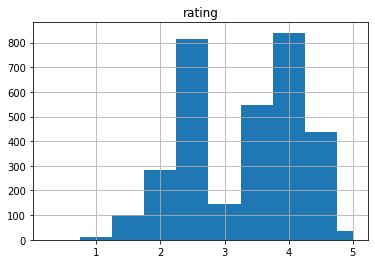

In [11]:
yelp_data.hist(column='rating',bins=[0.25,0.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75,5])

## Text Reviews and Ratings

In [12]:
# taking a closer look at the text reviews:
yelp_data.iloc[8]['reviews']

[['If you are looking for a sweet treat at Harvard Square definitely stop into milk bar... This is one of our favorite shops when we visit New York City so we...',
  4],
 ["I don't understand what the hype is about. I got a slice of their apple cider doughnut cake. There were layers of hard frosting and spiced apple jam, and...",
  2],
 ["Don't understand the hype of this place. Got the crunchy cereal milk shake, it was boring and nothing special. The soft serve flavor of the month was funnel...",
  2]]

In [13]:
reviews = []
ratings = []

for block_review in yelp_data['reviews']:
    if block_review:
        for review in block_review:
            reviews.append(review[0])
            ratings.append(review[1])

reviews = np.array(reviews)         
ratings = np.array(ratings)

print(f'sample review: {reviews[0]}')
print(f'corresponding rating: {ratings[0]}')
print(f'number of reviews/ratings: {ratings.size}')

sample review: Chinatown is flush with Chinese restaurants densely packed on every block - most of which, in my opinion at least, have adapted strongly to the American...
corresponding rating: 4
number of reviews/ratings: 9630


## Images

In [14]:
zip_obj = zipfile.ZipFile(f'{filepath}/foodPhotos.zip', mode='r')
zip_obj.namelist()[0:5]                 # small look into our namelist

['foodPhotos/',
 'foodPhotos/-5zFb3OJT40b_y1y-OYm3g.jpg',
 '__MACOSX/foodPhotos/._-5zFb3OJT40b_y1y-OYm3g.jpg',
 'foodPhotos/3HCtnuCU-fAyedmUldVNNA.jpg',
 '__MACOSX/foodPhotos/._3HCtnuCU-fAyedmUldVNNA.jpg']

Here is a sample image


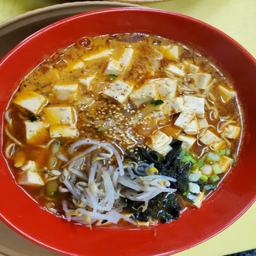

In [15]:
# a sample extraction
img_file = zip_obj.open(f'{zip_obj.namelist()[3]}')
img = Image.open(img_file)
img = img.resize((img_size, img_size))

print("Here is a sample image")
img

In [16]:
# we can convert the image to numpy array -> tensor:
img_sample_tensor = torch.tensor(np.array(img)).to(device)
img_sample_tensor = img_sample_tensor.float()
img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front
img_sample_tensor = torch.unsqueeze(img_sample_tensor, 0)
img_sample_tensor.shape

torch.Size([1, 3, 256, 256])

## Complete Image Extraction

**NOTE:** This section is completely deprecated in favour of dataloaders (do NOT run!)

In [17]:
# # now to get all of the images
# yelp_imgs = []

# for id in yelp_data['photo_id']:
#     temp_path = f'{zip_obj.namelist()[0]}{id}.jpg'
#     img_file = zip_obj.open(temp_path)
#     img = Image.open(img_file)
#     img = img.resize((img_size, img_size))
#     yelp_imgs.append(img)

In [18]:
# yelp_imgs = np.array(yelp_imgs)
# print(yelp_imgs)

# Text Data Prep

## Tokenizer and Embedding Model

In this section, we declare our embedding model which will be used to train our image-to-embedding CNN. This is done using the `HuggingFace` package, which features a pretrained BERT model.

In [19]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

text_1 = "Who was Jim Henson ?"
text_2 = "Jim Henson was a puppeteer"

# Tokenized input with special tokens around it (for BERT: [CLS] at the beginning and [SEP] at the end)
indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/main.zip" to /root/.cache/torch/hub/main.zip


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [20]:
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

# get our model
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# move our model to device
bert_model = bert_model.to(device)

In [22]:
data_extracted = np.array(yelp_data['reviews'].values)
for i in range(0, data_extracted.shape[0]):
    data_extracted[i] = np.array(data_extracted[i])

data_extracted = data_extracted.flatten()

In [23]:
# a sample tokenizer output:
test_token = tokenizer.encode(reviews[0], add_special_tokens=True)
token_tensor = torch.tensor([test_token]).to(device)

with torch.no_grad():
    test_embed = bert_model(token_tensor)[1]

print(f'Embedding vector produced with dimensionality: {test_embed.shape}')

Embedding vector produced with dimensionality: torch.Size([1, 768])


## Test/Train/Validation Splitting

In [24]:
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split(reviews, ratings, test_size = 0.3)
reviews_test, reviews_valid, ratings_test, ratings_valid = train_test_split(reviews_test, ratings_test, test_size=0.33)

print(f'review train/test/valid sizes: {reviews_train.size}/{reviews_test.size}/{reviews_valid.size}')
print(f'review train/test/valid sizes: {ratings_train.size}/{ratings_test.size}/{ratings_valid.size}')

review train/test/valid sizes: 6741/1935/954
review train/test/valid sizes: 6741/1935/954


## Text Embedding Dataloaders

Pytorch's DataLoaders let us define large datasets that can be processed from files as inputs to our model. Data loading is GPU parallelizable, which is a necessity given the size of our dataset.

In [25]:
# now, we convert all text to embeddings as necessary:
# pytorch's dataloader class will handle parallelization for us
class embedding_data(Dataset):
    def __init__(self, tokenizer=None, model=None, reviews=None, ratings=None, device=device):
        self.tokenizer = tokenizer
        self.model = model
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return self.reviews.size

    def __getitem__(self, idx):
        token = self.tokenizer.encode(self.reviews[idx], add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        rating = ratings[idx]

        return embed, rating

In [26]:
bert_data_train = embedding_data(tokenizer, bert_model, reviews_train)
bert_data_test = embedding_data(tokenizer, bert_model, reviews_test)
bert_data_valid = embedding_data(tokenizer, bert_model, reviews_valid)
print(f'This is a dataset entry dimension: {len(bert_data_train[0])}\n')

bert_loader_train = DataLoader(bert_data_train, batch_size=batch_size_text)
bert_loader_test = DataLoader(bert_data_test, batch_size=batch_size_text)
bert_loader_valid = DataLoader(bert_data_valid, batch_size=batch_size_text)
sample_bert_iterator = iter(bert_loader_train)

# a sample of our embedding loader (by iterating through it)
temp = next(sample_bert_iterator)
print(f'This is the dimensionality of a dataloader batch: {len(temp)}')
print(temp)
print(next(sample_bert_iterator))

This is a dataset entry dimension: 2

This is the dimensionality of a dataloader batch: 2
[tensor([[-0.6883,  0.4129,  0.9994,  ...,  0.9998, -0.8035,  0.9682],
        [-0.5840,  0.4133,  0.9993,  ...,  0.9998, -0.8664,  0.9573],
        [-0.5784,  0.3668,  0.9991,  ...,  0.9997, -0.8787,  0.9744],
        ...,
        [-0.5827,  0.3839,  0.9994,  ...,  0.9998, -0.8662,  0.9837],
        [-0.6746,  0.4178,  0.9998,  ...,  0.9999, -0.7883,  0.9872],
        [-0.6715,  0.4406,  0.9997,  ...,  0.9999, -0.7705,  0.9870]],
       device='cuda:0'), tensor([4, 4, 3, 5, 4, 3, 4, 3, 1, 4, 1, 3, 4, 3, 5, 4, 4, 3, 3, 5, 4, 4, 1, 5,
        4, 2, 2, 5, 4, 4, 5, 4, 4, 2, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 2, 4,
        5, 5, 5, 5, 4, 4, 5, 4, 4, 5, 5, 5, 5, 2, 3, 5])]
[tensor([[-0.5879,  0.4043,  0.9994,  ...,  0.9998, -0.8599,  0.9782],
        [-0.6446,  0.4189,  0.9997,  ...,  0.9999, -0.8601,  0.9894],
        [-0.6613,  0.3509,  0.9991,  ...,  0.9997, -0.8638,  0.9771],
        ...,
        

In [27]:
# note that at any time we can go back to the start be redeclaring the iterator
sample_bert_iterator = iter(bert_loader_train)
print(next(sample_bert_iterator))

[tensor([[-0.6883,  0.4129,  0.9994,  ...,  0.9998, -0.8035,  0.9682],
        [-0.5840,  0.4133,  0.9993,  ...,  0.9998, -0.8664,  0.9573],
        [-0.5784,  0.3668,  0.9991,  ...,  0.9997, -0.8787,  0.9744],
        ...,
        [-0.5827,  0.3839,  0.9994,  ...,  0.9998, -0.8662,  0.9837],
        [-0.6746,  0.4178,  0.9998,  ...,  0.9999, -0.7883,  0.9872],
        [-0.6715,  0.4406,  0.9997,  ...,  0.9999, -0.7705,  0.9870]],
       device='cuda:0'), tensor([4, 4, 3, 5, 4, 3, 4, 3, 1, 4, 1, 3, 4, 3, 5, 4, 4, 3, 3, 5, 4, 4, 1, 5,
        4, 2, 2, 5, 4, 4, 5, 4, 4, 2, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 2, 4,
        5, 5, 5, 5, 4, 4, 5, 4, 4, 5, 5, 5, 5, 2, 3, 5])]


# Image Data Prep

## Test/Train/Validation Splitting

In [28]:
df_train, df_test = train_test_split(yelp_data, test_size = 0.3)
df_test, df_valid = train_test_split(df_test, test_size=0.33)

df_test = df_test.reset_index()
df_valid = df_valid.reset_index()

df_train = df_train.reset_index()

print(f'review train/test/valid sizes: {len(df_train)}/{len(df_test)}/{len(df_valid)}')

review train/test/valid sizes: 2247/645/318


In [29]:
df_valid.head()

,level_0,index,photo_id,business_id,caption,label,rating,reviews
0,2589,589,KG8ntjMmTTp2mszhjp3o6A,E1UDrMc2Ks877UWuIiuYpg,,food,2.0,[[This Pizza Hut is fantastic. \n\nThe only do...
1,1196,1196,7LjAP8nULen6MzOKvLkefw,xK5nNxuaTc_g5VgPNv36xg,,food,4.5,"[[Amalia is the owner and baker, and she is as..."
2,2422,422,D66VNdcB5IeBcOtXsy8Mjw,krkEKmv30sqZ2BD6xhvzTQ,,food,2.0,[[This Pizza Hut will serve your food but not ...
3,643,643,SSoBWwzcnUE4nE7A_qtHMQ,17Re8ZuCYOw8ujOw9KviYg,,food,4.5,[[Seriously one of the best brunches I've had ...
4,2972,972,-oraDLLoMvRWioWK0UO04Q,5sq2ZICjFAs3AQPWuQVOag,,food,2.5,[[I had an average experience here. Obviously ...


In [30]:
type(df_valid['reviews'].values[2])

list

## Image Training Dataloaders

In [31]:
# pytorch's dataloader class will handle parallelization for us
class img_data(Dataset):
    def __init__(self, df=None, zip_obj=None, tokenizer=None, model=None, img_size=img_size, device=device):
        self.df = df
        self.zip_obj = zip_obj
        self.device=device
        self.img_size = img_size
        self.tokenizer = tokenizer
        self.model = model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get image
        img_id = self.df['photo_id'][idx]
        temp_path = f'{self.zip_obj.namelist()[0]}{img_id}.jpg'
        img_file = self.zip_obj.open(temp_path)
        img = Image.open(img_file)
        img = img.resize((self.img_size, self.img_size))

        img_sample_tensor = torch.tensor(np.array(img)).to(self.device)
        img_sample_tensor = img_sample_tensor.float()
        img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front

        # get reviews
        review_block = self.df['reviews'].values[idx]
        
        # get ratings 
        ratings_block = self.df['rating'].values[idx]

        # combine all reviews to get an overall rating
        review = ''
        for entry in review_block:
            review += entry[0]
            review += ' '

        token = self.tokenizer.encode(review, add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        img.close()
        img_file.close()

        return (img_sample_tensor, embed, ratings_block)

In [32]:
# here are our datasets
img_dataset_train = img_data(df_train, zip_obj, tokenizer, bert_model)
img_dataset_test = img_data(df_test, zip_obj, tokenizer, bert_model)
img_dataset_valid = img_data(df_valid, zip_obj, tokenizer, bert_model)

# we can index right into the directly as follows
sample_img, sample_embed, sample_ratings = img_dataset_train[2]
print(sample_img.shape)
print(sample_embed.shape)
print(sample_ratings)

torch.Size([3, 256, 256])
torch.Size([768])
4.0


In [33]:
img_loader_train = DataLoader(img_dataset_train, batch_size=batch_size)
img_loader_test = DataLoader(img_dataset_test, batch_size=batch_size)
img_loader_valid = DataLoader(img_dataset_valid, batch_size=batch_size)

temp = next(iter(img_loader_train))
print(temp[0].shape)
print(temp[1].shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 768])


# Architectures

## Master Parameters

In [34]:
# set parameters here:
conv1_kernel_size = 11
conv2_kernel_size = 5
conv1_features = 20
conv2_features = 30
stride1 = 4
stride2 = 2
pool_kernel_size = 5
embedding_size = 768
hidden_ff_size = 50

## Image-to-Sentiment CNN

In [35]:
# as a preliminary, we start with a basic CNN with pooling (will be subject to change)

class simple_CNN(nn.Module):
    def __init__(self, conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size):
                 
        super(simple_CNN, self).__init__()
        # some parameters:
        self.conv1_kernel_size = conv1_kernel_size   
        self.conv2_kernel_size = conv2_kernel_size
        self.conv1_features = conv1_features
        self.conv2_features = conv2_features
        self.stride1 = stride1
        self.stride2 = stride2
        self.pool_kernel_size = pool_kernel_size
        self.embedding_size = embedding_size
        self.img_channels = 3

        # the actual layers:
        self.conv1 = nn.Conv2d(self.img_channels, self.conv1_features, self.conv1_kernel_size)
        self.pool1 = nn.MaxPool2d(pool_kernel_size)
        self.norm1 = nn.BatchNorm2d(self.conv1_features)

        self.conv2 = nn.Conv2d(self.conv1_features, self.conv2_features, self.conv2_kernel_size)
        self.pool2 = nn.MaxPool2d(self.pool_kernel_size)
        self.norm2 = nn.BatchNorm2d(self.conv2_features)

        self.fc1 = nn.Linear(2430, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, self.embedding_size)

    def init_weights(self):
        '''
        initialize the layers (actual initializations are TBD)
        Linear initialization: uniform or Xavier might work here
        Conv initialization: Kaiming since we're using relu? literature says it's more effective
        '''
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.xavier_normal_(self.fc1.weight)        
        torch.nn.init.xavier_normal_(self.fc2.weight)                
        torch.nn.init.xavier_normal_(self.fc3.weight)                


    def forward(self, x):
        x = self.conv1(x).to(device)       # each conv layer consists of convolution -> activation func -> pooling
        x = self.pool1(F.relu(self.norm1(x)))

        x = self.conv2(x)
        x = self.pool2(F.relu(self.norm2(x)))

        x = x.view(-1, self.num_flat_features(x))                    # to feed into linear layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.tanh(self.fc3(x))  
        # x = self.fc1(x)
        # x = self.fc2(x)
        # x = torch.tanh(self.fc3(x))    

        return x      

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [36]:
my_CNN = simple_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size).to(device)
summary(my_CNN, (1, 3, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
simple_CNN                               --                        --
├─Conv2d: 1-1                            [1, 20, 246, 246]         7,280
├─BatchNorm2d: 1-2                       [1, 20, 246, 246]         40
├─MaxPool2d: 1-3                         [1, 20, 49, 49]           --
├─Conv2d: 1-4                            [1, 30, 45, 45]           15,030
├─BatchNorm2d: 1-5                       [1, 30, 45, 45]           60
├─MaxPool2d: 1-6                         [1, 30, 9, 9]             --
├─Linear: 1-7                            [1, 3000]                 7,293,000
├─Linear: 1-8                            [1, 1500]                 4,501,500
├─Linear: 1-9                            [1, 768]                  1,152,768
Total params: 12,969,678
Trainable params: 12,969,678
Non-trainable params: 0
Total mult-adds (M): 483.94
Input size (MB): 0.79
Forward/backward pass size (MB): 20.38
Params size (MB): 51.88
Estima

In [37]:
my_CNN.init_weights()
test = my_CNN(img_sample_tensor)
print(test[0][0:10])
print(test.shape)

tensor([ 0.1528,  0.0443,  0.5358, -0.4416, -0.1500, -0.0487, -0.3501, -0.5716,
         0.1290, -0.3464], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([1, 768])


## Sentiment-to-Rating NN

In [38]:
# this will take embedding vectors -> perform regression into a single 0-5 output
class linear_NN(nn.Module):
    def __init__(self, input_size, hidden_size):
            super(linear_NN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()               # do we want this to be multiplied by 5???
    
    def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            #output = self.sigmoid(output)
            return output.flatten()

    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.fc1.weight)        # since we use relu here
        torch.nn.init.xavier_normal_(self.fc2.weight)          # since we use sigmoid here

In [39]:
# quick test:
temp_inp = torch.rand((768)).to(device)
temp_linear_model = linear_NN(768, 50).to(device)
temp_linear_model.init_weights()
temp_linear_model(temp_inp)

tensor([0.0830], device='cuda:0', grad_fn=<AddBackward0>)

## Custom Embedding CNN

This notebook defines the components of a custom CNN architecture inspired by the semantic embedding to review prediction pipeline detailed by Tang et. al. After training the sentiment CNN and declaring our feed-forward network, all that's left is to connect the CNN output -> the feed-forward network. Training will be done on the two parts separately.

In [40]:
class embed_CNN(nn.Module):
    def __init__(self, conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size):
        super(embed_CNN, self).__init__()
        # store parameters for reference later:
        self.conv1_kernel_size = conv1_kernel_size
        self.conv2_kernel_size = conv2_kernel_size
        self.stride1 = stride1
        self.stride2 = stride2
        self.conv1_features = conv1_features
        self.conv2_features = conv2_features
        self.pool_kernel_size = pool_kernel_size
        self.embedding_size = embedding_size
        self.hidden_ff_size = hidden_ff_size

        # the two subarchitectures:
        self.CNN = simple_CNN(self.conv1_kernel_size, self.conv2_kernel_size, self.stride1, self.stride2, 
                 self.conv1_features, self.conv2_features, 
                 self.pool_kernel_size, self.embedding_size).to(device)
        self.linear = linear_NN(self.embedding_size, self.hidden_ff_size).to(device)

    def forward(self, x):
        x = self.CNN(x)
        x = self.linear(x)
        return x

    def CNN_forward(self, x):
        # for training purposes
        x  = self.CNN(x)
        return x

    def init_weights(self):
        self.CNN.init_weights()
        self.linear.init_weights()
        return 0

    def linear_forward(self, x):
        # for training purposes
        x = self.linear(x)
        return x

In [41]:
test_net = embed_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size).to(device)

test_net.init_weights()
test_net(img_sample_tensor)

tensor([-0.5002], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [42]:
summary(test_net, (1, 3, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
embed_CNN                                --                        --
├─simple_CNN: 1-1                        [1, 768]                  --
│    └─Conv2d: 2-1                       [1, 20, 246, 246]         7,280
│    └─MaxPool2d: 2-2                    --                        --
│    └─BatchNorm2d: 2-3                  [1, 20, 246, 246]         40
│    └─Conv2d: 2-4                       --                        (recursive)
│    └─MaxPool2d: 2-5                    [1, 20, 49, 49]           --
│    └─Conv2d: 2-6                       [1, 30, 45, 45]           15,030
│    └─BatchNorm2d: 2-7                  [1, 30, 45, 45]           60
│    └─MaxPool2d: 2-8                    [1, 30, 9, 9]             --
│    └─Linear: 2-9                       [1, 3000]                 7,293,000
│    └─Linear: 2-10                      [1, 1500]                 4,501,500
│    └─Linear: 2-11                      [1, 768]      

In [43]:
# USE TO LOAD IN SAVED MODELS
loaded_linear = torch.load(f'{weights_filepath}/lin_weights_4.pt')
loaded_CNN = torch.load(f'{weights_filepath}/CNN_weights_4.pt')
test_net.linear.load_state_dict(loaded_linear, strict=False)
test_net.CNN.load_state_dict(loaded_CNN, strict=False)

<All keys matched successfully>

# Training

## Embedding to Rating Training

In [ ]:
def train_one_epoch(epoch_index, tb_writer, optimizer, model, loss_fn):
    last_loss = 0.
    loss_list = []

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(bert_loader_train):
        print("batch", i)
        # Every data instance is an input + label pair
        bert_batch, rating_batch = data
        bert_batch = bert_batch.to(device)
        rating_batch = rating_batch.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(bert_batch).to(device)
        print(outputs[0])

        # Compute the loss and its gradients
        loss = loss_fn(outputs, rating_batch)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        loss_list.append(loss.item())

    loss_list = np.array(loss_list)
    loss_overall = np.sum(loss_list)/loss_list.size
    return loss_overall

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

optimizer = torch.optim.Adam(test_net.linear.parameters(), lr = 1e-5)
loss_fn = torch.nn.MSELoss()

epoch_number = 0
EPOCHS = 8
best_vloss = float('inf')

lin_loss_arr = np.zeros(EPOCHS)
lin_tloss_arr = np.zeros(EPOCHS)

for epoch in tqdm(range(int(EPOCHS)),desc="Training Epochs"):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    test_net.linear.train(True)
    
    lin_loss = train_one_epoch(epoch_number, writer, optimizer, test_net.linear,loss_fn)
    lin_loss_arr[epoch_number] = lin_loss

    # We don't need gradients on to do reporting
    test_net.linear.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(bert_loader_test):
        vinputs, vlabels = vdata
        vlabels = vlabels.to(device)
        voutputs = test_net.linear(vinputs).to(device)
        vloss = loss_fn(voutputs, vlabels).to(device)
        running_vloss += vloss.detach()

        del vloss
        del voutputs

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} test {}'.format(lin_loss, avg_vloss))

    lin_tloss_arr[epoch_number] = avg_vloss

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Test Loss',
                    { 'Training' : lin_loss, 'Test' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'linmodel_{}_{}'.format(timestamp, epoch_number)
        torch.save(test_net.linear.state_dict(), model_path)

    epoch_number += 1

Training Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1:
batch 0
tensor(-0.1647, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(-0.1257, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(-0.2018, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(-0.1795, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(-0.0937, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(-0.1143, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(-0.1110, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(-0.0860, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(-0.0767, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(-0.0677, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(-0.0541, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(0.0486, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(0.0090, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(-0.0128, device='cuda:0', grad_fn=<SelectBackward0>)
batch 14
tensor(0.0932, device='cuda:

Training Epochs:  12%|█▎        | 1/8 [01:25<09:59, 85.68s/it]

LOSS train 11.98152637031843 test 6.844628810882568
EPOCH 2:
batch 0
tensor(1.8013, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(1.8282, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(1.7612, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(1.7178, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(1.8533, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(1.8297, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(1.7921, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(1.8064, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(1.8070, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(1.8329, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(1.8777, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(1.9690, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(1.9207, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(1.8752, device='cuda:0', grad_fn=<SelectBackward0

Training Epochs:  25%|██▌       | 2/8 [02:50<08:31, 85.26s/it]

LOSS train 3.896349531299663 test 2.214679718017578
EPOCH 3:
batch 0
tensor(3.2470, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.2095, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.1071, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.0706, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.2342, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.1951, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.1464, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.1665, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.1589, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.1706, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.2002, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(3.3207, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(3.2650, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.1262, device='cuda:0', grad_fn=<SelectBackward0

Training Epochs:  38%|███▊      | 3/8 [04:14<07:03, 84.75s/it]

LOSS train 1.9371210269208223 test 1.4847244024276733
EPOCH 4:
batch 0
tensor(3.8071, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.7467, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.6335, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.5941, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.7663, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.7023, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.6220, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.6695, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.6455, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.6735, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.6869, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(3.8015, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(3.7443, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.5795, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs:  50%|█████     | 4/8 [05:38<05:37, 84.30s/it]

LOSS train 1.6996211285861034 test 1.3866523504257202
EPOCH 5:
batch 0
tensor(3.9606, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.8931, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.7742, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.7309, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.9063, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.8346, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.7491, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.7980, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.7713, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.8011, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.8112, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(3.9244, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(3.8643, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.6921, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs:  62%|██████▎   | 5/8 [07:01<04:11, 83.82s/it]

LOSS train 1.6740845700479903 test 1.3733744621276855
EPOCH 6:
batch 0
tensor(3.9872, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.9181, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.7955, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.7510, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.9260, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.8551, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.7697, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.8126, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.7879, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.8153, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.8263, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(3.9420, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(3.8770, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.7040, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs:  75%|███████▌  | 6/8 [08:24<02:46, 83.45s/it]

LOSS train 1.6718974664526165 test 1.3730000257492065
EPOCH 7:
batch 0
tensor(3.9859, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.9164, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.7909, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.7458, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.9197, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.8515, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.7674, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.8031, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.7814, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.8056, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.8187, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(3.9369, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(3.8674, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.6951, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs:  88%|████████▊ | 7/8 [09:46<01:23, 83.17s/it]

LOSS train 1.6729633054643307 test 1.3746106624603271
EPOCH 8:
batch 0
tensor(3.9799, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.9104, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.7821, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.7367, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.9094, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.8434, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.7619, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.7900, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.7716, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.7926, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.8078, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(3.9283, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(3.8548, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.6833, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs: 100%|██████████| 8/8 [11:09<00:00, 83.68s/it]

LOSS train 1.6743694279553756 test 1.3765963315963745


In [ ]:
model_path = 'lin_weights_4.pt'
torch.save(test_net.linear.state_dict(), model_path)
np.savetxt("FCN_train_loss4.csv", lin_loss_arr, delimiter=",")
np.savetxt('FCN_test_loss4.csv', lin_tloss_arr, delimiter=",")

In [49]:
lin_loss_arr = np.loadtxt(f'{loss_filepath}/FCN_train_loss4.csv', delimiter=',')
lin_tloss_arr = np.loadtxt(f'{loss_filepath}/FCN_test_loss4.csv', delimiter=',')

Text(0.5, 0, 'Epoch')

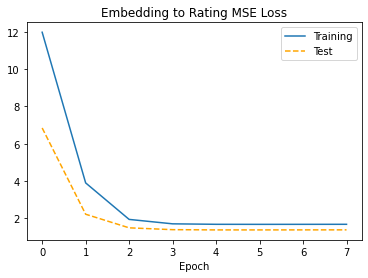

In [50]:
fig, ax = plt.subplots()
ax.plot(lin_loss_arr, label='Training')
ax.plot(lin_tloss_arr, linestyle='--', color='orange', label='Test')
ax.set_title('Embedding to Rating MSE Loss')
ax.legend()
ax.set_xlabel('Epoch')

## Image to Embedding Training

In [ ]:
def train_one_epoch_CNN(epoch_index, tb_writer, optimizer, model, loss_fn):
    last_loss = 0.
    loss_list = []

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(img_loader_train):
        print("batch", i)
        # Every data instance is an input + label pair
        img_batch, bert_batch, dummy = data
        img_batch = img_batch.to(device)
        bert_batch = bert_batch.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(img_batch).to(device)

        sampleidx = random.randint(0, 3)

        print(outputs[sampleidx][0:10])
        print(outputs[sampleidx+1][0:10])

        # Compute the loss and its gradients
        loss = loss_fn(outputs, bert_batch)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        loss_list.append(loss.item())
        del loss
        del outputs

    loss_list = np.array(loss_list)
    loss_overall = np.sum(loss_list)/loss_list.size
    return loss_overall

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

optimizer = torch.optim.Adam(test_net.CNN.parameters(), lr = 1e-5)
loss_fn = torch.nn.MSELoss()

epoch_number = 0
EPOCHS = 8
best_vloss = float('inf')

loss_arr = np.zeros(EPOCHS)
test_loss_arr = np.zeros(EPOCHS)

for epoch in tqdm(range(int(EPOCHS)),desc="Training Epochs"):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    test_net.CNN.train(True)
    
    avg_loss = train_one_epoch_CNN(epoch_number, writer, optimizer, test_net.CNN,loss_fn)
    print('Moving onto test set...')

    loss_arr[epoch_number] = avg_loss

    # We don't need gradients on to do reporting
    test_net.CNN.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(img_loader_test):
        vinputs, vlabels, dummy = vdata
        vlabels = vlabels.to(device)
        # vlabels = vlabels.to('cpu')
        voutputs = test_net.CNN(vinputs)
        vloss = loss_fn(voutputs, vlabels).to(device)
        running_vloss += vloss.detach()

        del dummy
        del vloss
        del vlabels
        del voutputs

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} Test {}'.format(avg_loss, avg_vloss))

    test_loss_arr[epoch_number] = avg_vloss

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Test Loss',
                    { 'Training' : avg_loss, 'Test' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'cnnmodel_{}_{}'.format(timestamp, epoch_number)
    torch.save(test_net.CNN.state_dict(), model_path)

    epoch_number += 1
    torch.cuda.empty_cache()

Training Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1:
batch 0
tensor([ 0.3655,  0.3644, -0.4903, -0.9068,  0.6318,  0.3069, -0.4725,  0.1003,
        -0.7345, -0.5261], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3651,  0.3326, -0.4302, -0.9123,  0.6748,  0.2829, -0.5148,  0.0775,
        -0.7258, -0.5022], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([ 0.2067,  0.3525, -0.4229, -0.9088,  0.6823,  0.2711, -0.4312,  0.1114,
        -0.7085, -0.5251], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3313,  0.3175, -0.4600, -0.9166,  0.6414,  0.3254, -0.4481,  0.0875,
        -0.7218, -0.5131], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([ 0.2056,  0.3835, -0.4241, -0.9138,  0.6792,  0.3086, -0.4637,  0.0735,
        -0.7446, -0.5486], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3024,  0.3452, -0.4527, -0.9222,  0.6636,  0.3379, -0.4628,  0.1529,
        -0.7500, -0.5606], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tensor([ 0.1971,  0.3659, -0.3538, -0.9104,  0.6696,  0.319

Training Epochs:  12%|█▎        | 1/8 [01:12<08:27, 72.47s/it]

LOSS train 0.5381459767619768 Test 0.3195294439792633
EPOCH 2:
batch 0
tensor([-0.2197,  0.3200,  0.3437, -0.8993,  0.7555,  0.4925,  0.1622, -0.1378,
        -0.8076, -0.5659], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.1820,  0.2757,  0.3519, -0.9065,  0.7888,  0.4710,  0.0956, -0.1736,
        -0.7957, -0.5499], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.3418,  0.3308,  0.3689, -0.9022,  0.7841,  0.4582,  0.2031, -0.1444,
        -0.7872, -0.5697], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.2308,  0.2778,  0.3302, -0.9115,  0.7672,  0.5195,  0.1835, -0.1623,
        -0.7982, -0.5643], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.3142,  0.3359,  0.3644, -0.9002,  0.7833,  0.5105,  0.1948, -0.1853,
        -0.8114, -0.5709], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.2479,  0.3063,  0.3242, -0.9163,  0.7801,  0.5227,  0.1413, -0.1350,
        -0.8212, -0.5956], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tenso

Training Epochs:  25%|██▌       | 2/8 [02:25<07:16, 72.79s/it]

LOSS train 0.20359858829114172 Test 0.11835646629333496
EPOCH 3:
batch 0
tensor([-0.4428,  0.3163,  0.6200, -0.9061,  0.8459,  0.6293,  0.4839, -0.4596,
        -0.8575, -0.5504], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.4541,  0.2949,  0.5998, -0.9093,  0.8286,  0.6440,  0.4962, -0.4269,
        -0.8476, -0.5742], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.4317,  0.3731,  0.5506, -0.9194,  0.8513,  0.6349,  0.4916, -0.4174,
        -0.8484, -0.5476], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.4339,  0.3920,  0.5176, -0.9205,  0.8602,  0.6094,  0.4509, -0.4197,
        -0.8514, -0.5686], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.4699,  0.3673,  0.5811, -0.9173,  0.8468,  0.6233,  0.4660, -0.4323,
        -0.8568, -0.5631], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.4272,  0.3345,  0.5990, -0.9166,  0.8529,  0.6230,  0.4824, -0.4490,
        -0.8478, -0.5642], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
ten

Training Epochs:  38%|███▊      | 3/8 [03:37<06:03, 72.64s/it]

LOSS train 0.07899180251277155 Test 0.051415931433439255
EPOCH 4:
batch 0
tensor([-0.4952,  0.3295,  0.6981, -0.9410,  0.8897,  0.7132,  0.6240, -0.6017,
        -0.8724, -0.5514], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5164,  0.3133,  0.6804, -0.9417,  0.8818,  0.7192,  0.6268, -0.5828,
        -0.8670, -0.5589], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.4934,  0.3910,  0.6288, -0.9487,  0.8951,  0.6958,  0.5971, -0.5716,
        -0.8703, -0.5693], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.4604,  0.3867,  0.6293, -0.9474,  0.8884,  0.7043,  0.6091, -0.5798,
        -0.8718, -0.5645], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.4831,  0.3257,  0.6858, -0.9392,  0.8870,  0.7217,  0.6377, -0.5678,
        -0.8760, -0.5700], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5159,  0.3864,  0.6563, -0.9445,  0.8909,  0.7065,  0.6317, -0.5881,
        -0.8772, -0.5563], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
te

Training Epochs:  50%|█████     | 4/8 [04:50<04:50, 72.64s/it]

LOSS train 0.03768961172964838 Test 0.02766226977109909
EPOCH 5:
batch 0
tensor([-0.5646,  0.3385,  0.7487, -0.9587,  0.9125,  0.7692,  0.7067, -0.6869,
        -0.8922, -0.5572], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5753,  0.3241,  0.7332, -0.9585,  0.9071,  0.7745,  0.7073, -0.6757,
        -0.8890, -0.5583], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.6001,  0.3966,  0.7221, -0.9606,  0.9112,  0.7527,  0.6991, -0.6669,
        -0.8873, -0.5673], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5488,  0.3558,  0.7143, -0.9622,  0.9077,  0.7752,  0.6909, -0.6717,
        -0.8914, -0.5690], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.5530,  0.3320,  0.7428, -0.9563,  0.9106,  0.7782,  0.7135, -0.6659,
        -0.8956, -0.5710], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5791,  0.3850,  0.7218, -0.9604,  0.9110,  0.7653,  0.7076, -0.6752,
        -0.8968, -0.5625], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
ten

Training Epochs:  62%|██████▎   | 5/8 [06:02<03:37, 72.49s/it]

LOSS train 0.022774061395062342 Test 0.018749743700027466
EPOCH 6:
batch 0
tensor([-0.5987,  0.3410,  0.8008, -0.9685,  0.9191,  0.8036,  0.7570, -0.7371,
        -0.9027, -0.5601], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6060,  0.3250,  0.7889, -0.9684,  0.9141,  0.8079,  0.7578, -0.7297,
        -0.9008, -0.5586], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.5718,  0.3764,  0.7645, -0.9698,  0.9156,  0.7985,  0.7422, -0.7283,
        -0.9031, -0.5664], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6295,  0.3872,  0.7825, -0.9694,  0.9174,  0.7908,  0.7491, -0.7246,
        -0.8990, -0.5690], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.6114,  0.3802,  0.7825, -0.9696,  0.9164,  0.7996,  0.7571, -0.7267,
        -0.9065, -0.5605], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5898,  0.3624,  0.7639, -0.9727,  0.9161,  0.8087,  0.7328, -0.7173,
        -0.9071, -0.5788], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
t

Training Epochs:  75%|███████▌  | 6/8 [07:15<02:25, 72.53s/it]

LOSS train 0.016545278071943257 Test 0.014380856417119503
EPOCH 7:
batch 0
tensor([-0.6016,  0.3610,  0.8131, -0.9746,  0.9153,  0.8285,  0.7775, -0.7637,
        -0.9095, -0.5726], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5846,  0.3493,  0.8127, -0.9762,  0.9210,  0.8214,  0.7735, -0.7698,
        -0.9083, -0.5577], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.6032,  0.3800,  0.8053, -0.9757,  0.9183,  0.8211,  0.7739, -0.7645,
        -0.9090, -0.5728], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.5866,  0.3739,  0.8065, -0.9747,  0.9158,  0.8230,  0.7787, -0.7683,
        -0.9090, -0.5652], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.6198,  0.3631,  0.8236, -0.9742,  0.9147,  0.8294,  0.7828, -0.7716,
        -0.9105, -0.5553], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6044,  0.3407,  0.8320, -0.9743,  0.9188,  0.8278,  0.7835, -0.7730,
        -0.9074, -0.5569], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
t

Training Epochs:  88%|████████▊ | 7/8 [08:27<01:12, 72.35s/it]

LOSS train 0.013269124656087823 Test 0.011892249807715416
EPOCH 8:
batch 0
tensor([-0.6185,  0.3417,  0.8590, -0.9776,  0.9174,  0.8461,  0.8154, -0.8021,
        -0.9131, -0.5666], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6230,  0.3279,  0.8505, -0.9778,  0.9128,  0.8485,  0.8152, -0.7986,
        -0.9112, -0.5601], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([-0.5929,  0.3724,  0.8350, -0.9778,  0.9138,  0.8403,  0.8045, -0.7987,
        -0.9127, -0.5642], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6454,  0.3776,  0.8482, -0.9779,  0.9158,  0.8362,  0.8090, -0.7961,
        -0.9098, -0.5712], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([-0.6284,  0.3769,  0.8475, -0.9782,  0.9138,  0.8406,  0.8151, -0.7948,
        -0.9152, -0.5573], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.6116,  0.3573,  0.8354, -0.9798,  0.9150,  0.8476,  0.7965, -0.7912,
        -0.9160, -0.5754], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
t

Training Epochs: 100%|██████████| 8/8 [09:39<00:00, 72.44s/it]

LOSS train 0.011319569079205394 Test 0.010335500352084637


Text(0.5, 1.0, 'CNN Training: Average MSE Loss')

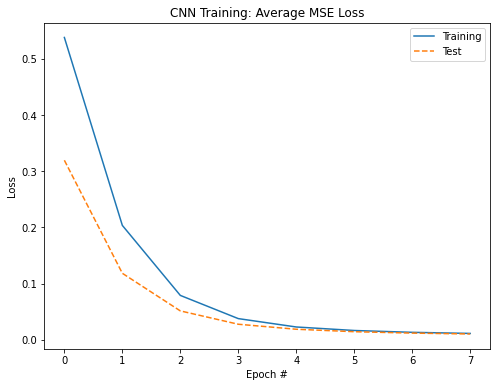

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(loss_arr, label='Training')
ax.plot(test_loss_arr, linestyle='--', label='Test')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch #')
ax.legend()
ax.set_title('CNN Training: Average MSE Loss')

In [ ]:
# save the model
torch.save(test_net.CNN.state_dict(), 'CNN_weights_4.pt')
np.savetxt("CNN_train_loss4.csv", loss_arr, delimiter=",")
np.savetxt('CNN_test_loss4.csv', test_loss_arr, delimiter=",")

# Final Results

## Test Results

In [51]:
loss_fn = nn.MSELoss()
test_loss_list = []
pred_list = []

for i, data in enumerate(img_loader_test):
    img_batch, dummy, rating_batch = data

    pred_ratings = test_net(img_batch)
    pred_list.append(pred_ratings.detach().cpu().numpy())
    batch_loss = loss_fn(rating_batch.to(device), pred_ratings).to(device)

    test_loss_list.append(batch_loss.item())

test_loss_list = np.array(test_loss_list)
pred_list = np.array(pred_list)

total_tloss = np.sum(test_loss_list)
avg_tloss = np.mean(test_loss_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [52]:
print(f'This is our average MSE test loss: {avg_tloss}')

This is our average MSE test loss: 0.8291988911661974


## Validation Results

In [53]:
loss_fn = nn.MSELoss()
valid_loss_list = []
valid_pred_list = []
valid_rating_list = []

for i, data in enumerate(img_loader_valid):
    img_batch, dummy, rating_batch = data

    pred_ratings = test_net(img_batch)
    batch_loss = loss_fn(rating_batch.to(device), pred_ratings).to(device)
    
    valid_pred_list.append(pred_ratings.detach().cpu().numpy())
    valid_rating_list.append(rating_batch)
    valid_loss_list.append(batch_loss.item())

valid_loss_list = np.array(valid_loss_list)

total_vloss = np.sum(valid_loss_list)
avg_vloss = np.mean(valid_loss_list)

In [54]:
print(f'Final validation loss for trained model (normalized MSE): {avg_vloss}')

Final validation loss for trained model (normalized MSE): 0.8443246586552325


In [55]:
valid_rating_list = np.concatenate(valid_rating_list).ravel()
valid_pred_list = np.concatenate(valid_pred_list).ravel()

residuals = valid_rating_list - valid_pred_list

correct_mask = residuals < 0.5
percent_correct = np.sum(correct_mask)/correct_mask.size


In [56]:
percent_correct

0.6698113207547169